In [1]:
set.seed(1234) #set seed

#loading libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(cowplot)
library(modeldata)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# loading cleaveland dataset
# column names were chosen based on the existing column names in dataset
# except for num, which was changed to diag, short for diagnosis

cleveland_data<-read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
         col_names=c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","diag")) 
head(cleveland_data)

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  diag = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diag
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [3]:
cleveland_filtered_data <- cleveland_data %>%
                    select(age,trestbps,thalach,chol,oldpeak,diag)%>% #selected the categories decided on (explained below)
                    filter(diag==0|diag==1) %>% #only selected diag values of 0 and 1; values 2-4 were found originally but dataset didn't say what those values meant
                    mutate(diag = as.factor(diag)) %>% #changed diag (target variable) from double -> factor
                    filter(!is.na(age), !is.na(trestbps), !is.na(thalach), !is.na(chol), !is.na(oldpeak), !is.na(diag)) #if any NA's in each column, removes them

head(cleveland_filtered_data)

age,trestbps,thalach,chol,oldpeak,diag
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,150,233,2.3,0
67,120,129,229,2.6,1
37,130,187,250,3.5,0
41,130,172,204,1.4,0
56,120,178,236,0.8,0
57,120,163,354,0.6,0


In [4]:
set.seed(1234)
cleveland_split<-initial_split(cleveland_filtered_data,prop=0.75,strata=diag)  #splitting cleveland's data 
cleveland_training<-training(cleveland_split)
cleveland_testing<-testing(cleveland_split)

In [18]:
set.seed(1234)

#split 1
split_1 <- initial_split(cleveland_filtered_data, strata=diag, prop=0.8)
part_1 <- testing(split_1)

#split 2
split_2 <- initial_split(training(split_1), strata=diag, prop=0.75)
part_2 <- testing(split_2)

#split 3
split_3 <- initial_split(training(split_2), strata=diag, prop=2/3)
part_3 <- testing(split_3)

#split 4
split_4 <- initial_split(training(split_3), strata=diag, prop=0.5)
part_4 <- testing(split_4)

#split 5
part_5 <- training(split_4)

#combining 4 to make "training" and leaving 1 for validation
train_1 <- rbind(part_1, part_2, part_3, part_4)
val_1 <- part_5

train_2 <- rbind(part_1, part_2, part_3, part_5)
val_2 <- part_4

train_3 <- rbind(part_1, part_2, part_5, part_4)
val_3 <- part_3

train_4 <- rbind(part_1, part_5, part_3, part_4)
val_4 <- part_2

train_5 <- rbind(part_5, part_2, part_3, part_4)
val_5 <- part_1

In [19]:
# all knn values
set.seed(1234)

knn_4 <- nearest_neighbor(weight_func = "rectangular", neighbors=4) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_8 <- nearest_neighbor(weight_func = "rectangular", neighbors=8) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_12 <- nearest_neighbor(weight_func = "rectangular", neighbors=12) %>%
    set_engine("kknn") %>%
    set_mode("classification")
# knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors=tune()) %>%
#   set_engine("kknn") %>%
#   set_mode("classification")

# grid_vals <- tibble(neighbors = seq(from = 1, to = 20))

In [20]:
#upsampling 
set.seed(1234)

upsample_recipe_1 <- recipe(diag ~ age + trestbps + chol + thalach + oldpeak, data = train_1) %>%
    step_upsample(diag, over_ratio = 1, skip = TRUE) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

upsample_recipe_2 <- recipe(diag ~ age + trestbps + chol + thalach + oldpeak, data = train_2) %>%
    step_upsample(diag, over_ratio = 1, skip = TRUE) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

upsample_recipe_3 <- recipe(diag ~ age + trestbps + chol + thalach + oldpeak, data = train_3) %>%
    step_upsample(diag, over_ratio = 1, skip = TRUE) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

upsample_recipe_4 <- recipe(diag ~ age + trestbps + chol + thalach + oldpeak, data = train_4) %>%
    step_upsample(diag, over_ratio = 1, skip = TRUE) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

upsample_recipe_5 <- recipe(diag ~ age + trestbps + chol + thalach + oldpeak, data = train_5) %>%
    step_upsample(diag, over_ratio = 1, skip = TRUE) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

In [21]:
# fit for k4
set.seed(1234)

#upsampling 1
knn_fit_1_k4 <- workflow() %>%
     add_recipe(upsample_recipe_1) %>%
     add_model(knn_4) %>%
     fit(data=train_1)

#upsampling 2
knn_fit_2_k4 <- workflow() %>%
     add_recipe(upsample_recipe_2) %>%
     add_model(knn_4) %>%
     fit(data=train_2)

#upsampling 3
knn_fit_3_k4 <- workflow() %>%
     add_recipe(upsample_recipe_3) %>%
     add_model(knn_4) %>%
     fit(data=train_3)

#upsampling 4
knn_fit_4_k4 <- workflow() %>%
     add_recipe(upsample_recipe_4) %>%
     add_model(knn_4) %>%
     fit(data=train_4)

#upsampling 5
knn_fit_5_k4 <- workflow() %>%
     add_recipe(upsample_recipe_5) %>%
     add_model(knn_4) %>%
     fit(data=train_5)

In [17]:
#predict and accuracies for k4
set.seed(1234)

#upsampling 1
predict_1_k4 <- predict(knn_fit_1_k4, val_1) %>%
    bind_cols(val_1)

accuracies_1_k4 <- predict_1_k4 %>% 
     metrics(truth = diag, estimate = .pred_class) %>%
     filter(.metric == "accuracy")

#upsampling 2
predict_2_k4 <- predict(knn_fit_2_k4, val_1) %>%
    bind_cols(val_1)

accuracies_2_k4 <- predict_2_k4 %>% 
     metrics(truth = diag, estimate = .pred_class) %>%
     filter(.metric == "accuracy")

#upsampling 3
predict_3_k4 <- predict(knn_fit_3_k4, val_1) %>%
    bind_cols(val_1)

accuracies_3_k4 <- predict_3_k4 %>% 
     metrics(truth = diag, estimate = .pred_class) %>%
     filter(.metric == "accuracy")

#upsampling 4
predict_4_k4 <- predict(knn_fit_4_k4, val_1) %>%
    bind_cols(val_1)

accuracies_4_k4 <- predict_2_k4 %>% 
     metrics(truth = diag, estimate = .pred_class) %>%
     filter(.metric == "accuracy")

#upsampling 5
predict_5_k4 <- predict(knn_fit_5_k4, val_1) %>%
    bind_cols(val_1)

accuracies_5_k4 <- predict_5_k4 %>% 
     metrics(truth = diag, estimate = .pred_class) %>%
     filter(.metric == "accuracy")

In [22]:
#k4 accuracy overall
set.seed(1234)

accuracy_all_k4 <- rbind(accuracies_1_k4, accuracies_2_k4, accuracies_3_k4, accuracies_4_k4, accuracies_5_k4)
accuracy_k_k4 <- accuracy_all_k4 %>%
                summarize(mean = mean(.estimate))

accuracy_k_k4

mean
<dbl>
0.8133333


In [23]:
#fitting for k8
set.seed(1234)

#upsampling 1
knn_fit_1_k8 <- workflow() %>%
     add_recipe(upsample_recipe_1) %>%
     add_model(knn_8) %>%
     fit(data=train_1)

#upsampling 2
knn_fit_2_k8 <- workflow() %>%
     add_recipe(upsample_recipe_2) %>%
     add_model(knn_8) %>%
     fit(data=train_2)

#upsampling 3
knn_fit_3_k8 <- workflow() %>%
     add_recipe(upsample_recipe_3) %>%
     add_model(knn_8) %>%
     fit(data=train_3)

#upsampling 4
knn_fit_4_k8 <- workflow() %>%
     add_recipe(upsample_recipe_4) %>%
     add_model(knn_8) %>%
     fit(data=train_4)

#upsampling 5
knn_fit_5_k8 <- workflow() %>%
     add_recipe(upsample_recipe_5) %>%
     add_model(knn_8) %>%
     fit(data=train_5)

In [24]:
#predict and accuracies with k8
set.seed(1234)

#upsampling 1
predict_1_k8 <- predict(knn_fit_1_k8, val_1) %>%
    bind_cols(val_1)

accuracies_1_k8 <- predict_1_k8 %>% 
     metrics(truth = diag, estimate = .pred_class) %>%
     filter(.metric == "accuracy")

#upsampling 2
predict_2_k8 <- predict(knn_fit_2_k8, val_2) %>%
    bind_cols(val_2)

accuracies_2_k8 <- predict_2_k8 %>% 
     metrics(truth = diag, estimate = .pred_class) %>%
     filter(.metric == "accuracy")

#upsampling 3
predict_3_k8 <- predict(knn_fit_3_k8, val_3) %>%
    bind_cols(val_3)

accuracies_3_k8 <- predict_3_k8 %>% 
     metrics(truth = diag, estimate = .pred_class) %>%
     filter(.metric == "accuracy")

#upsampling 4
predict_4_k8 <- predict(knn_fit_4_k8, val_4) %>%
    bind_cols(val_4)

accuracies_4_k8 <- predict_4_k8 %>% 
     metrics(truth = diag, estimate = .pred_class) %>%
     filter(.metric == "accuracy")

#upsampling 5
predict_5_k8 <- predict(knn_fit_5_k8, val_5) %>%
    bind_cols(val_5)

accuracies_5_k8 <- predict_5_k8 %>% 
     metrics(truth = diag, estimate = .pred_class) %>%
     filter(.metric == "accuracy")

In [25]:
#k8 accuracy overall
set.seed(1234)

accuracy_all_k8 <- rbind(accuracies_1_k8, accuracies_2_k8, accuracies_3_k8, accuracies_4_k8, accuracies_5_k8)
accuracy_k_k8 <- accuracy_all_k8 %>%
                summarize(mean = mean(.estimate))

accuracy_k_k8

mean
<dbl>
0.5799423


In [26]:
set.seed(1234)

#fit upsampling 1->5 to knn_12

#upsampling 1
knn_fit_1_k12 <- workflow() %>%
     add_recipe(upsample_recipe_1) %>%
     add_model(knn_12) %>%
     fit(data=train_1)

#upsampling 2
knn_fit_2_k12 <- workflow() %>%
     add_recipe(upsample_recipe_2) %>%
     add_model(knn_12) %>%
     fit(data=train_2)

#upsampling 3
knn_fit_3_k12 <- workflow() %>%
     add_recipe(upsample_recipe_3) %>%
     add_model(knn_12) %>%
     fit(data=train_3)

#upsampling 4
knn_fit_4_k12 <- workflow() %>%
     add_recipe(upsample_recipe_4) %>%
     add_model(knn_12) %>%
     fit(data=train_4)

#upsampling 5
knn_fit_5_k12 <- workflow() %>%
     add_recipe(upsample_recipe_5) %>%
     add_model(knn_12) %>%
     fit(data=train_5)

In [27]:
#upsampling 1
set.seed(1234)

predict_1_k12 <- predict(knn_fit_1_k12, val_1) %>%
    bind_cols(val_1)

accuracies_1_k12 <- predict_1_k12 %>% 
     metrics(truth = diag, estimate = .pred_class) %>%
     filter(.metric == "accuracy")

#upsampling 2
predict_2_k12 <- predict(knn_fit_2_k12, val_2) %>%
    bind_cols(val_2)

accuracies_2_k12 <- predict_2_k12 %>% 
     metrics(truth = diag, estimate = .pred_class) %>%
     filter(.metric == "accuracy")

#upsampling 3
predict_3_k12 <- predict(knn_fit_3_k12, val_3) %>%
    bind_cols(val_3)

accuracies_3_k12 <- predict_3_k12 %>% 
     metrics(truth = diag, estimate = .pred_class) %>%
     filter(.metric == "accuracy")

#upsampling 4
predict_4_k12 <- predict(knn_fit_4_k12, val_4) %>%
    bind_cols(val_4)

accuracies_4_k12 <- predict_4_k12 %>% 
     metrics(truth = diag, estimate = .pred_class) %>%
     filter(.metric == "accuracy")

#upsampling 5
predict_5_k12 <- predict(knn_fit_5_k12, val_5) %>%
    bind_cols(val_5)

accuracies_5_k12 <- predict_5_k12 %>% 
     metrics(truth = diag, estimate = .pred_class) %>%
     filter(.metric == "accuracy")

In [28]:
# accuracies for three values of k (k4,k8,k12)
set.seed(1234)

#k4 accuracy overall

accuracy_all_k4 <- rbind(accuracies_1_k4, accuracies_2_k4, accuracies_3_k4, accuracies_4_k4, accuracies_5_k4)
accuracy_k_k4 <- accuracy_all_k4 %>%
                summarize(mean = mean(.estimate))

accuracy_k_k4

#k8 accuracy overall

accuracy_all_k8 <- rbind(accuracies_1_k8, accuracies_2_k8, accuracies_3_k8, accuracies_4_k8, accuracies_5_k8)
accuracy_k_k8 <- accuracy_all_k8 %>%
                summarize(mean = mean(.estimate))

accuracy_k_k8

#k12 accuracy overall

accuracy_k12 <- rbind(accuracies_1_k12, accuracies_2_k12, accuracies_3_k12, accuracies_4_k12, accuracies_5_k12) %>%
                summarize(mean = mean(.estimate))

accuracy_k12

mean
<dbl>
0.8133333


mean
<dbl>
0.5799423


mean
<dbl>
0.5441847


In [32]:
# using k = 4 to train the model!

knn_final <- 4
knn_select <- nearest_neighbor(weight_func = "rectangular", neighbors=knn_final) %>%
  set_engine("kknn") %>%
  set_mode("classification")

#which recipe hm
#heart_recipe <- recipe(diag ~ age + trestbps + chol + thalach + oldpeak, data = cleveland_training) %>%
#    step_scale(all_predictors()) %>%
#    step_center(all_predictors()) %>%
#    prep()

#heart_recipe_upscale <- recipe(diag ~ age + trestbps + thalach + chol + oldpeak, data = cleveland_training) %>%
#    step_upsample(diag, over_ratio = 1, skip = TRUE) %>%
#    step_scale(all_predictors()) %>%
#    step_center(all_predictors()) %>%
#    prep()

knn_fit_final <- workflow() %>%
     add_recipe(heart_recipe) %>%
     add_model(knn_select) %>%
     fit(data = cleveland_training)

pred_final <- predict(knn_fit_final, cleveland_testing) %>%
    bind_cols(cleveland_testing)

accuracy_final <- pred_final %>%
    metrics(truth = diag, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

accuracy_final


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7037037


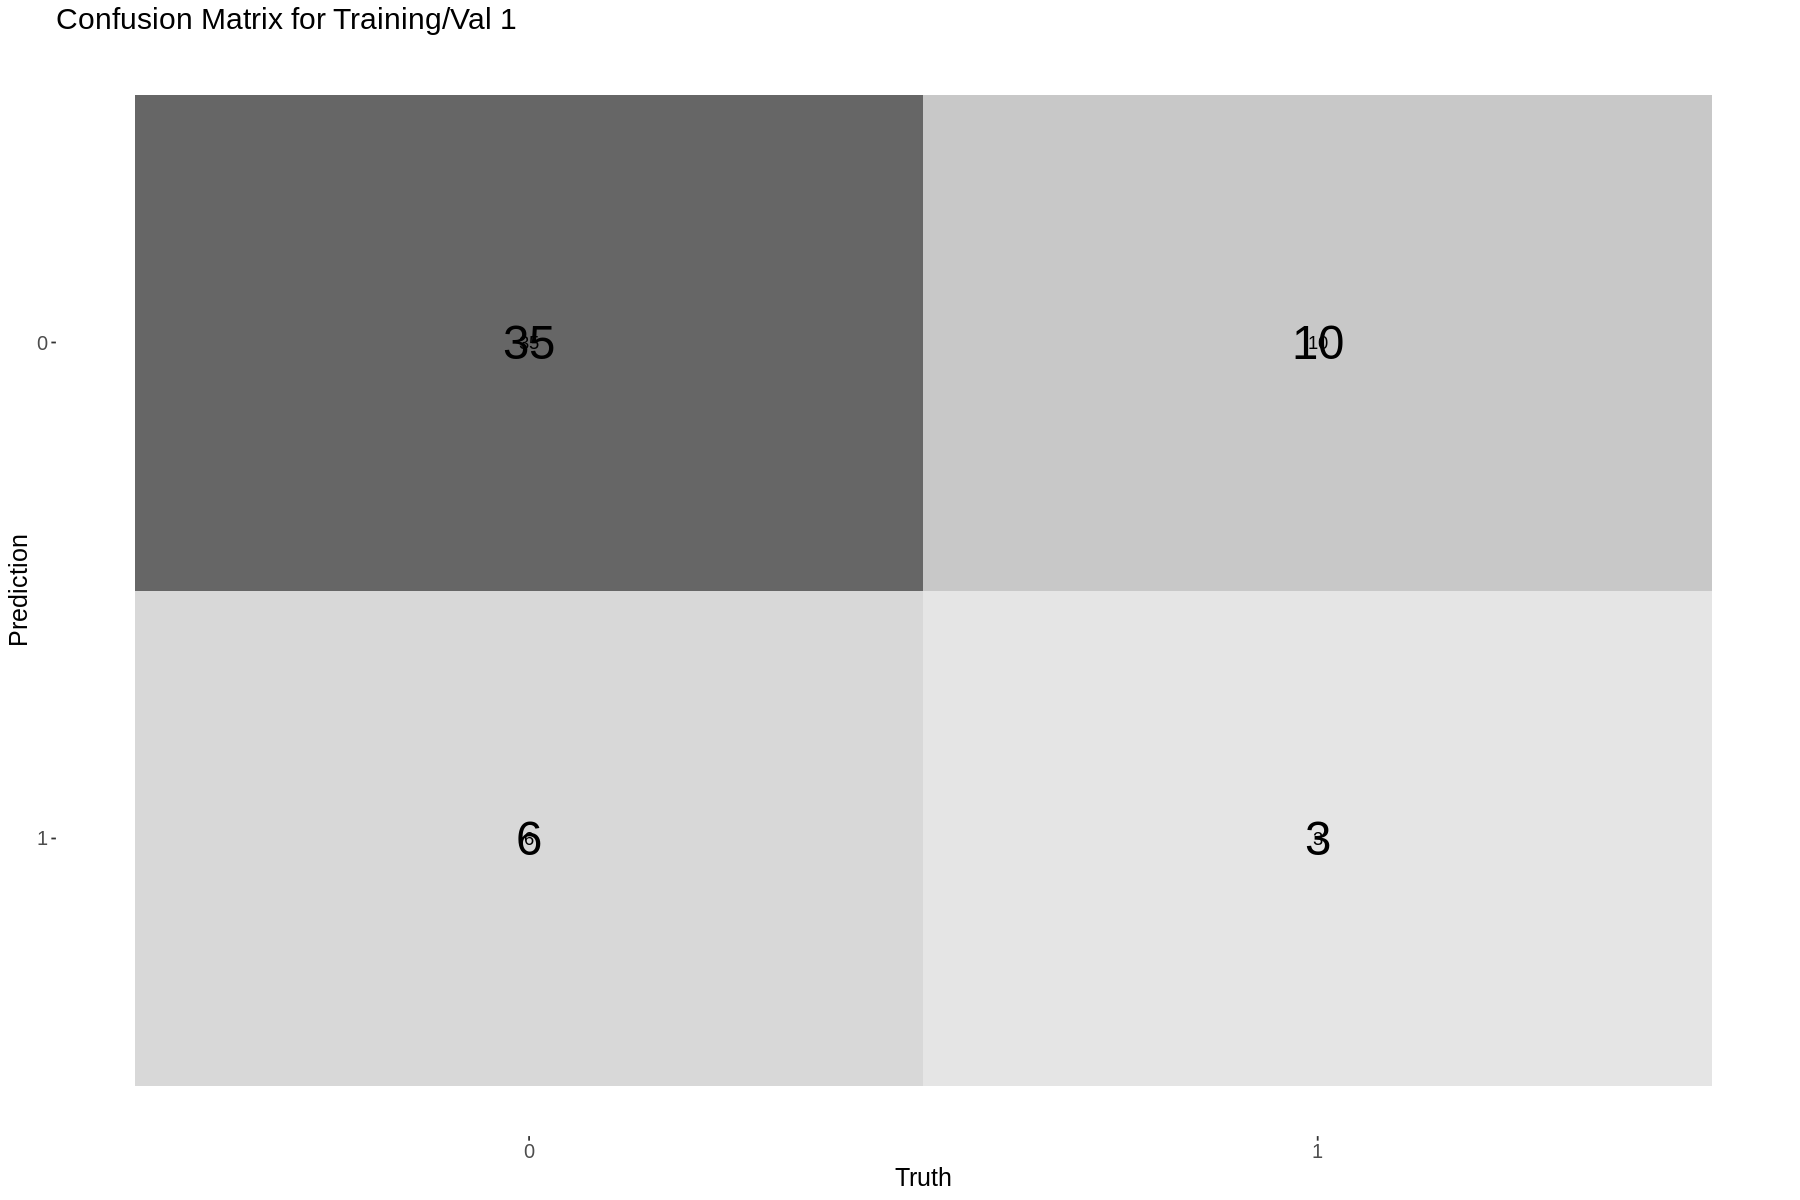

In [33]:
options(repr.plot.width=15, repr.plot.height=10) 
confusion_matrix_final <- conf_mat(pred_final, truth = diag, estimate = .pred_class)
confusion_matrix_final1 <- autoplot(confusion_matrix_final, type = "heatmap") + theme(text = element_text(size = 15)) + 
    ggtitle("Confusion Matrix for final") +
    geom_text(aes(label = Freq), size=10)

confusion_matrix_final1